<a href="https://colab.research.google.com/github/BisacciaAdriana/Credit_Scoring/blob/main/Scoring_de_Credito_Regresion_Logistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [ ]:
%cd '/content/MyDrive/MyDrive/Entregas'

/content/MyDrive/MyDrive/Entregas


**Objetivo**

El scoring de crédito es un modelo estadístico que permiten hacer una predicción del riesgo de la operación para los clientes, es decir, estimar probabilidades de default y ordenar a los deudores y solicitantes de financiamiento posicionándolos en un ranking, o un score según su propensión al riesgo.

La modelación con regresión logística es el principal método que se utiliza en la estimación de morosidad, es una de las herramientas del scoring crediticio donde se desea ir clasificando e identificando que tipo de cliente se le puede otorgar el crédito y a quien no.

Existen diversas métricas estadísticas que indican el nivel de bondad del modelo, en este trabajo se realizarán los cálculos del Estadístico coeficiente de Gini, la curva Roc y el área bajo la curva. El objetivo de esta tesina actuarial es analizar si la regresión logística con penalización Ridge puede ser una mejor metodología de modelización, en comparación al modelo de regresión logística tradicional. A partir de estos modelos se realiza la comparación sobre las métricas propuestas. 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve






In [ ]:
df1 = pd.read_csv('B1_Clientes1.csv', sep=';', index_col=0, encoding='latin-1')
print('Registros Base 1:', df1.shape[0])

df1 = df1[df1['DefaultInicio']==0]                      # Filtro los que no tiene default al inicio
print('Sin default inicio:', df1.shape[0])


Registros Base 1: 520496
Sin default inicio: 449359


In [ ]:
df2 = pd.read_csv('B1_Clientes2.csv', sep=';', index_col=0, encoding='latin-1')
print('Registros Base 2:', df2.shape[0])

df2 = df2[df2['Tiene_Performance']==1]                  # Filtro por los que si tienen historia crediticia
print('Base 2 con historial:', df2.shape[0])

mdf0= pd.merge(df2, df1, how="inner", on=["CUIT"])      # Merge de los df1 y df2 por la columna CUIT 
print('Lista completa filtrada:', mdf0.shape[0])




Registros Base 2: 520476
Base 2 con historial: 345551
Lista completa filtrada: 287665


In [ ]:
df3 = pd.read_csv('B1_Clientes3.csv', sep=';', index_col=0, encoding='latin-1')
print('Registros Base 2:', df2.shape[0])

mdf1=pd.merge(mdf0, df3, how="inner", on=["CUIT"])
print('Lista completa filtrada:', mdf0.shape[0])



Registros Base 2: 345551
Lista completa filtrada: 287665


In [ ]:
mdf2=mdf1.drop_duplicates() #eliminamos datos duplicados
print('Lista completa filtrada:', mdf2.shape[0])

Lista completa filtrada: 285371


In [ ]:
# Borro el dataframe para liberar memoria
del df1    
del df2     
del df3

Para el presente trabajo de investigación se tomó información histórica entre julio 2019 y junio 2020. Esta base de datos surge de un banco del sistema financiero local argentino con variables socioeconómicas, financieras, geográficas, de contacto y de comportamiento crediticio, entre otras. 

Las variables de dicha base que se utilizaron para el armado de los modelos son las siguientes:


*   NSEPercentil: Percentil sobre el Nivel Socioeconómico, los individuos son clasificados en niveles socioeconómicos en función de los ingresos mensuales pronosticados. 
*   EsBancarizado: 1 si posee cuenta bancaria y 0 si no posee ninguna. 
*   Tendencia_12: tendencia de score social de los clientes en los últimos 12 meses y se clasifica en creciente, decreciente, estable y NC.
*   TieneAtrasoCuotUlt6M, tiene atraso en cuotas los últimos 6 meses, 1 si tiene atraso y 0 si no tiene.
*   CantMesesNeg11, cantidad de meses en que se encuentra con saldo negativo en el producto crediticio.
*   Score: un puntaje que representa el riesgo de crédito. 
*   Edad: Edad al momento de scoring.
*   AntigüedadEnBancos: medido en meses, antigüedad desde apertura de la primera cuenta bancaria.
*   JuicioComoDemandado: cantidad de juicios que tiene el cliente como demandado.
*   MontoDeuda: contiene la deuda actualizada de todos los individuos del mercado argentino.
*   CompromisosMensuales: desembolsos mensuales que los individuos tienen comprometidos para atender sus deudas en el sistema financiero.




In [ ]:
mdf3 = mdf2.loc[:,['Target','NSEPercentil','EsBancarizado','Tendencia_12','TieneAtrasoCuotUlt6M','CantMesesNeg11','Score','Edad','AntiguedadEnBancos','JuicioComoDemandado', 'MontoDeuda', 'CompromisosMensuales']]


In [ ]:
mdf3.describe().T

,count,mean,std,min,25%,50%,75%,max
Target,285371.0,0.063114,0.243169,0.0,0.0,0.0,0.0,1.0
NSEPercentil,285371.0,62.257924,29.789185,1.0,38.0,67.0,91.0,100.0
EsBancarizado,285371.0,0.944238,0.229463,0.0,1.0,1.0,1.0,1.0
TieneAtrasoCuotUlt6M,285371.0,0.130735,0.337111,0.0,0.0,0.0,0.0,1.0
CantMesesNeg11,285371.0,0.095626,0.737407,0.0,0.0,0.0,0.0,11.0
Score,285371.0,511.395419,224.742213,0.0,363.0,527.0,674.0,999.0
Edad,285371.0,51.016939,15.142563,0.0,39.0,50.0,62.0,110.0
AntiguedadEnBancos,285371.0,136.901710,72.433064,0.0,72.0,143.0,199.0,240.0
JuicioComoDemandado,285371.0,0.000035,0.006485,0.0,0.0,0.0,0.0,2.0
MontoDeuda,285371.0,149512.630393,772416.439342,0.0,13976.0,47000.0,126000.0,174539000.0


Se llevó a cabo una limpieza de los datos, encontrando errores y valores atípicos como por ejemplo en la variable CompromisosMensuales, lo que permitió descartar dicha variable. También se eliminó la variable MontoDeuda debido a se encuentran en valores nominales lo que dificulta la credibilidad de la variable a lo largo del tiempo. 

In [ ]:
mdf3 = mdf3.loc[:,['Target','NSEPercentil','EsBancarizado','Tendencia_12','TieneAtrasoCuotUlt6M','CantMesesNeg11','Score','Edad','AntiguedadEnBancos','JuicioComoDemandado']]

In [ ]:
print(mdf3['Tendencia_12'].unique())

['Creciente' 'Decreciente' 'Estable' 'NC']


In [ ]:
mdf = pd.get_dummies(mdf3, columns = ['Tendencia_12'])
mdf.head()

,Target,NSEPercentil,EsBancarizado,TieneAtrasoCuotUlt6M,CantMesesNeg11,Score,Edad,AntiguedadEnBancos,JuicioComoDemandado,Tendencia_12_Creciente,Tendencia_12_Decreciente,Tendencia_12_Estable,Tendencia_12_NC
0,0,91,1,0,0,469,68,133,0,1,0,0,0
1,1,96,1,0,0,409,65,62,0,1,0,0,0
2,0,96,1,1,0,80,68,64,0,1,0,0,0
3,0,94,1,1,0,1,68,104,0,0,1,0,0
4,0,75,1,1,5,165,67,218,0,1,0,0,0


In [ ]:
mdf.describe().T

,count,mean,std,min,25%,50%,75%,max
Target,285371.0,0.063114,0.243169,0.0,0.0,0.0,0.0,1.0
NSEPercentil,285371.0,62.257924,29.789185,1.0,38.0,67.0,91.0,100.0
EsBancarizado,285371.0,0.944238,0.229463,0.0,1.0,1.0,1.0,1.0
TieneAtrasoCuotUlt6M,285371.0,0.130735,0.337111,0.0,0.0,0.0,0.0,1.0
CantMesesNeg11,285371.0,0.095626,0.737407,0.0,0.0,0.0,0.0,11.0
Score,285371.0,511.395419,224.742213,0.0,363.0,527.0,674.0,999.0
Edad,285371.0,51.016939,15.142563,0.0,39.0,50.0,62.0,110.0
AntiguedadEnBancos,285371.0,136.901710,72.433064,0.0,72.0,143.0,199.0,240.0
JuicioComoDemandado,285371.0,0.000035,0.006485,0.0,0.0,0.0,0.0,2.0
Tendencia_12_Creciente,285371.0,0.189448,0.391865,0.0,0.0,0.0,0.0,1.0


**Correlación entre variables**

En los modelos de regresión logística múltiple las variables deben ser independientes, no debe de haber correlación entre ellos. La correlación ocurre cuando una variable está linealmente relacionada con una o varias de las otras variables del modelo. Como consecuencia, no se puede identificar de forma precisa el efecto individual que tiene cada variable sobre la variable respuesta, lo que se traduce en un incremento de la varianza de los coeficientes de regresión estimados. Además, pequeños cambios en los datos provocan grandes cambios en las estimaciones de los coeficientes.

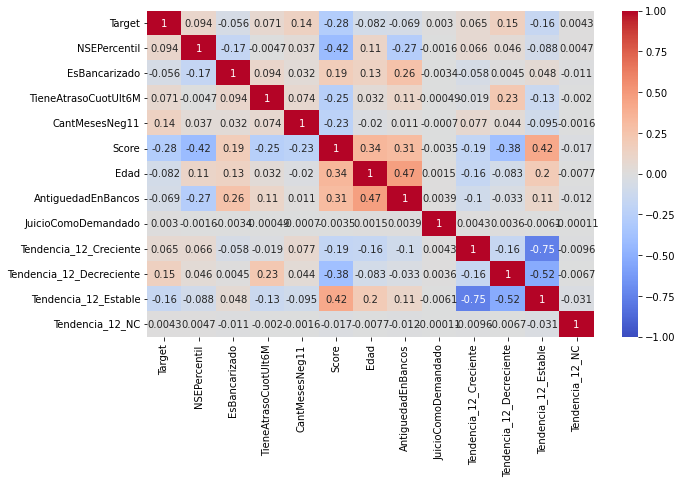

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(data=mdf.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')
plt.savefig('Correlación entre variables')
plt.show()

En la matriz de correlación se puede observar los coeficientes de correlación de cada variable con todas las demás. Como los valores mínimo y máximo son 0 y ±1 seguiremos el siguiente criterio para segmentarlas: 0.20 será una relación baja y 0.85 indicará una relación que ya podemos considerar grande. Con el objetivo de poder aplicar y que tenga efecto la penalización Ridge en el modelo.

Podemos observar que la diagonal tiene valor 1 porque la correlación de cada variable consigo mismo es perfecta. Luego se encuentran correlaciones estadísticamente significativas, ninguna correlación es mayor a 0.85 por lo que todas las variables superan el filtro de correlación. 


In [ ]:
X = mdf.loc[:, mdf.columns !='Target']
y = mdf.loc[:, mdf.columns == 'Target']

In [ ]:
pd.reset_option('display.max_rows')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(199759, 12)
(85612, 12)


La base de datos cuenta con 285.371 registro de diferentes de clientes. Para el desarrollo del modelo la población se dividió en población de entrenamiento, son los datos que se utilizan para el entrenamiento del modelo y la población de testeo, son los datos que se reservaron para comprobar si el modelo generado a partir de los datos de entrenamiento funciona, es decir, si las respuestas predichas por el modelo para un caso totalmente nuevo son acertadas o no. Se repartió en un 70% para datos de entrenamiento y 30% para datos de testeo. Finalmente, la población de entrenamiento cuenta con 199.759 registros y la población de testeo con 85.612 registros.



**Regresión Logística**

La modelación con regresión logística es el principal método que se utiliza para la estimación de la morosidad, es una de las herramientas del Scoring de Credito, donde se desea ir clasificando e identificando que tipo de cliente se le puede otorgar el crédito y a quien no.

La regresión logística es un modelo estadístico que utiliza la función logística que devuelve valores entre 0 y 1. Sea Y una variable dependiente binaria con los posibles valores: 0 ( si no ocurre el suceso, en este caso que no ocurra default por parte del cliente) y 1 ( si ocurre el suceso, en este caso si hay default). Sean un conjunto de k variables independientes, X1, X2, …, Xk, observadas con el fin de predecir y explicar el valor de Y. 


In [ ]:
logreg = LogisticRegression(max_iter=1800, penalty='none') 
baseline_model_cv = cross_validate(logreg, X_train, y_train, cv= StratifiedKFold(n_splits=5),
n_jobs=-1, scoring='roc_auc')



In [ ]:
logreg.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=1800, penalty='none')

Es necesario establecer un límite (threshold), un rango de puntuación de crédito partir del cual se considera que la variable pertenece a uno de los niveles. Cada entidad bancaria tiene una opinión diferente donde se encuentra el umbral entre el buen y el mal crédito. Por ejemplo, para este trabajo se asignó una observación al grupo 1 o de Default si la probabilidad estimada es mayor al 0.06 y al grupo 0 el resto.

Una vez realizado el modelo con los datos disponibles se tiene que comprobar su capacidad prediciendo las nuevas observaciones que no se hayan empleado para entrenarlo, de este modo se verifica si el modelo se puede generalizar. 


In [ ]:
# seteamos el threshold de 6%:

THRESHOLD = 0.06
y_pred =(logreg.predict_proba(X_test)[:, 1]>THRESHOLD).astype('float') # el "1" en la columna del vector es para capturar solamente la probabilidad de y=1
y_pred_train = (logreg.predict_proba(X_train)[:, 1] > THRESHOLD).astype('float')

**Métricas**

Una etapa importante del desarrollo del modelo implica la validación de su precisión predictiva a través de una serie de pruebas estadísticas.

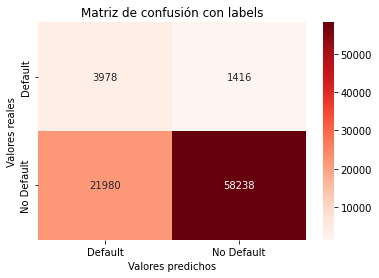

In [ ]:
# TEST:
ax= plt.subplot()
labels = [1,0]
co_test = confusion_matrix(y_test, y_pred, labels=labels)
sns.heatmap(co_test,annot=True,fmt='d', cmap= 'Reds', ax=ax) 
# labels, title and ticks
ax.set_xlabel('Valores predichos');ax.set_ylabel('Valores reales');
ax.xaxis.set_ticklabels(['Default', 'No Default']); ax.yaxis.set_ticklabels(['Default', 'No Default']);
ax.set_title('Matriz de confusión con labels');
plt.savefig("Matriz de Confusión")
plt.show()

In [ ]:
 from sklearn import metrics

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# Recall : 
print('Recall: %.3f' % recall_score(y_train, y_pred_train))
# Precision: 
print('Precision: %.3f' % precision_score(y_train, y_pred_train))
#Accurancy	
print('Accuracy: %.3f' % accuracy_score(y_train, y_pred_train))


Recall: 0.727
Precision: 0.152
Accuracy: 0.727


**Recall**: representa la capacidad del modelo para predecir correctamente los positivos a partir de los positivos reales. 

tp / (tp + fn) donde tp es el número de
verdaderos positivos y fn el número de falsos negativos.

El mejor valor es 1 y el peor valor es 0. 

**Precision**: la precisión es la capacidad del clasificador de no etiquetar como positiva una muestra que es negativa.

El mejor valor es 1 y el peor valor es 0.

Si queremos minimizar los falsos negativos, elegiríamos un modelo con alta precisión. Por el contrario, si queremos minimizar los falsos positivos, elegiríamos un modelo con alto recall


**Accurancy**: proporción de verdaderos positivos y verdaderos negativos con respecto a todas las observaciones positivas y negativas.En otras palabras, accurancy nos dice con qué frecuencia podemos esperar que nuestro modelo de aprendizaje automático prediga correctamente un resultado del número total de veces que hizo predicciones

La curva ROC permite comparar diferentes modelos para identificar cual otorga mejor rendimiento como clasificador. Por otro lado, a partir de esta curva podemos calcular el área debajo de la curva (AUC) que se utiliza como resumen de la calidad del modelo.

El AUC es el estadístico para medir la capacidad discriminante de la prueba, mide la probabilidad de que un buen cliente elegido al azar tenga una puntuación más alta que un mal cliente elegido al azar.

En el grafico a continuación podemos observar la curva ROC de los dos modelos desarrollados regresión logística y regresión logística con penalización Ridge. Un clasificador aleatorio (que asignará 0 o 1 al azar) estaría representado en rojo. Es decir, por azar, el 50% de las predicciones serían acertadas.


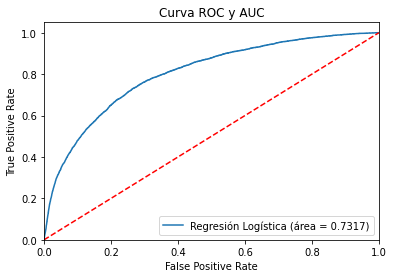

In [ ]:
logistic_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test,logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Regresión Logística (área = %0.4f)'% logistic_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC y AUC')
plt.legend(loc='lower right')
plt.savefig('Log_ROC')
plt.show()

La curva ROC permite comparar diferentes modelos para identificar cual otorga mejor rendimiento como clasificador. Por otro lado, a partir de esta curva podemos calcular el área debajo de la curva (AUC) que se utiliza como resumen de la calidad del modelo.

El AUC es el estadístico para medir la capacidad discriminante de la prueba, mide la probabilidad de que un buen cliente elegido al azar tenga una puntuación más alta que un mal cliente elegido al azar.

En el grafico a continuación podemos observar la curva ROC de los dos modelos desarrollados regresión logística y regresión logística con penalización Ridge. Un clasificador aleatorio (que asignará 0 o 1 al azar) estaría representado en rojo. Es decir, por azar, el 50% de las predicciones serían acertadas.


In [ ]:
auc = roc_auc_score(y_test, y_pred)
print('AUC - Test Set: %.4f%%' % (auc*100))
Gini = (2 * auc) - 1
print('Gini - Test Set: %.4f%%' % (Gini*100))

AUC - Test Set: 73.1741%
Gini - Test Set: 46.3483%


In [ ]:
feature_name = X.columns
summary_table = pd.DataFrame(columns=['Feature name'], data = feature_name)
summary_table['Coefficient'] = np.transpose(logreg.coef_[0])
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', logreg.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table['Odds Ratio'] = np.exp(summary_table['Coefficient'])
summary_table.sort_values('Odds Ratio', ascending = False)
summary_table



,Feature name,Coefficient,Odds Ratio
0,Intercept,-0.657017,0.518396
1,NSEPercentil,0.001226,1.001227
2,EsBancarizado,-0.060349,0.941436
3,TieneAtrasoCuotUlt6M,-0.058995,0.942711
4,CantMesesNeg11,0.076641,1.079654
5,Score,-0.005010,0.995002
6,Edad,0.004288,1.004297
7,AntiguedadEnBancos,-0.000047,0.999953
8,JuicioComoDemandado,0.000517,1.000517
9,Tendencia_12_Creciente,-0.083999,0.919432


In [ ]:
# armamos el dataframe para ver la performance del modelo:
probs = (logreg.predict_proba(X_test)[:, 1])
df_logregprob = pd.DataFrame(probs)
df_logregprob['prob_default'] = df_logregprob[0]
df_logregprob = df_logregprob.drop([0], axis=1)
df_logregprob

,prob_default
0,0.003260
1,0.011448
2,0.026622
3,0.083325
4,0.015293
...,...
85607,0.058573
85608,0.023189
85609,0.092777
85610,0.034974


In [ ]:
# armamos la tabla de performance del modelo:

df_perf = pd.DataFrame(y_pred)
df_perf = pd.concat([df_perf, df_logregprob], axis=1)
df1_perf = pd.DataFrame(y_test)

df1_perf = df1_perf.reset_index()
df_perf = pd.concat([df_perf, df1_perf], axis=1)

df_perf_test = df_perf.drop(['index'], axis=1)
df_perf_test['pred_class'] = df_perf_test[0]
df_perf_test = df_perf_test.drop([0], axis=1)


In [ ]:
# sacar el parametro duplicates

df_perf_test = df_perf_test.sort_values(by=['prob_default'], ascending=True, axis=0)
df_perf_test['decile'] = pd.qcut(df_perf_test['prob_default'], 10, labels=False, duplicates='drop')
df_perf_test

,prob_default,Target,pred_class,decile
43029,0.002341,0,0.0,0
24233,0.002383,0,0.0,0
8942,0.002441,0,0.0,0
61688,0.002457,0,0.0,0
38600,0.002474,0,0.0,0
...,...,...,...,...
30960,0.548213,0,1.0,9
36746,0.565812,0,1.0,9
38103,0.566765,0,1.0,9
72844,0.573096,0,1.0,9


In [ ]:
mins = df_perf_test.groupby('decile').prob_default.min().reset_index()
maxs = df_perf_test.groupby('decile').prob_default.max()
avgs = df_perf_test.groupby('decile').prob_default.mean()
num = df_perf_test.groupby('decile').prob_default.count()
num_def = df_perf_test.groupby('decile')['Target'].sum()
def_rate = num_def/num

tabla = mins

for i in [maxs, avgs, num, num_def,def_rate]: 
  tabla= pd.concat([tabla, i], axis=1)

tabla.columns = ['decile','min','max','average','count','defaults','default_rate']
tabla


,decile,min,max,average,count,defaults,default_rate
0,0,0.002341,0.008156,0.005671,8562,48,0.005606
1,1,0.008156,0.012639,0.010359,8561,94,0.010980
2,2,0.012639,0.017796,0.015135,8561,153,0.017872
3,3,0.017798,0.023923,0.020766,8561,178,0.020792
4,4,0.023923,0.032009,0.027783,8561,237,0.027684
5,5,0.032011,0.043359,0.037329,8561,307,0.035860
6,6,0.043362,0.060694,0.051351,8561,415,0.048476
7,7,0.060694,0.090985,0.074341,8561,683,0.079780
8,8,0.090989,0.161432,0.119754,8561,991,0.115758
9,9,0.161450,0.582732,0.271074,8562,2288,0.267227


Obtenemos una Tabla de Performance de clientes abiertas por deciles de score permite validar la calidad de predicción del modelo de scoring, mostrando el score a una fecha y los defaults ocurridos 12 meses después. 

**Penalización Ridge**

La penalización o regularización se refiere a una técnica que introduce un término de penalización a la función objetivo. Una de las técnicas más simples y comunes para imponer restricciones a los coeficientes es la regresión Ridge.

Fue introducida principalmente para reducir el problema de colinealidad de las variables explicativas, el cual funciona reduciendo los coeficientes mediante la introducción de una penalización sobre cuán grandes pueden ser.

Cuando hay muchas variables correlacionadas en un modelo de regresión lineal, sus coeficientes pueden determinarse de manera deficiente y exhibir una varianza alta. Al imponer una restricción de tamaño a los coeficientes, se alivia este problema.

A esta penalización tiene el efecto de reducir de forma proporcional el valor de todos los coeficientes del modelo pero sin que estos lleguen a cero. El grado de penalización está controlado por el hiperparámetro λ. Cuando λ=0, la penalización es nula y el resultado es equivalente al de un modelo lineal por mínimos cuadrados ordinarios (OLS). A medida que λ aumenta, mayor es la penalización y menor el valor de los predictores.



In [ ]:
logreg_ridge = LogisticRegression(penalty='l2', solver='liblinear')
baseline_model_cv = cross_validate(logreg_ridge, X_train, y_train, cv= StratifiedKFold(n_splits=5),
n_jobs=-1, scoring='roc_auc')

In [ ]:
logreg_ridge.fit(X_test, y_test.values.ravel())

LogisticRegression(solver='liblinear')

In [ ]:
# seteamos el threshold de 6%:

THRESHOLD = 0.06
y_pred_ridge =(logreg_ridge.predict_proba(X_test)[:, 1]>THRESHOLD).astype('float') # el "1" en la columna del vector es para capturar solamente la probabilidad de y=1
y_pred_train_ridge = (logreg_ridge.predict_proba(X_train)[:, 1] > THRESHOLD).astype('float')

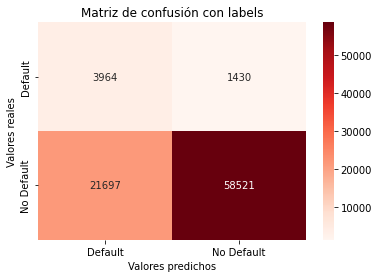

In [ ]:
# TEST:
ax= plt.subplot()
labels = [1,0]
co_test = confusion_matrix(y_test, y_pred_ridge, labels=labels)
sns.heatmap(co_test,annot=True,fmt='d', cmap= 'Reds', ax=ax) 
# labels, title and ticks
ax.set_xlabel('Valores predichos');ax.set_ylabel('Valores reales');
ax.xaxis.set_ticklabels(['Default', 'No Default']); ax.yaxis.set_ticklabels(['Default', 'No Default']);
ax.set_title('Matriz de confusión con labels');
plt.savefig('Matriz de confusión Ridge')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# Recall : 
print('Recall: %.3f' % recall_score(y_train, y_pred_train_ridge))
# Precision: 
print('Precision: %.3f' % precision_score(y_train, y_pred_train_ridge))
#Accurancy	
print('Accuracy: %.3f' % accuracy_score(y_train, y_pred_train_ridge))

Recall: 0.724
Precision: 0.154
Accuracy: 0.731


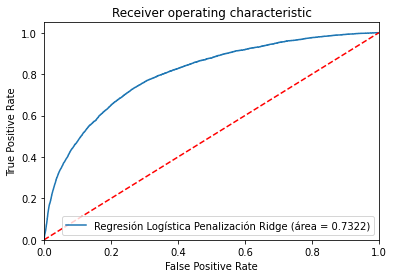

In [ ]:
logistic_ridge_roc_auc = roc_auc_score(y_test, y_pred_ridge)
fpr, tpr, thresholds = roc_curve(y_test,logreg_ridge.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Regresión Logística Penalización Ridge (área = %0.4f)'% logistic_ridge_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right')
plt.savefig('Log_ROC_Ridge')
plt.show()

In [ ]:
auc_ridge = roc_auc_score(y_test, y_pred_ridge)
print('AUC - Test Set: %.4f%%' % (auc_ridge*100))
Gini_ridge = (2 * auc_ridge) - 1
print('Gini - Test Set: %.4f%%' % (Gini_ridge*100))

AUC - Test Set: 73.2208%
Gini - Test Set: 46.4415%


In [ ]:
feature_name_ridge = X.columns
summary_table_ridge = pd.DataFrame(columns=['Feature name'], data = feature_name_ridge)
summary_table_ridge['Coefficient Ridge'] = np.transpose(logreg_ridge.coef_[0])
summary_table_ridge.index = summary_table_ridge.index + 1
summary_table_ridge.loc[0] = ['Intercept', logreg_ridge.intercept_[0]]
summary_table_ridge = summary_table_ridge.sort_index()
summary_table_ridge['Odds Ratio'] = np.exp(summary_table['Coefficient'])
summary_table_ridge.sort_values('Odds Ratio', ascending = False)
summary_table_ridge

,Feature name,Coefficient Ridge,Odds Ratio
0,Intercept,-0.601017,0.518396
1,NSEPercentil,0.000377,1.001227
2,EsBancarizado,-0.121192,0.941436
3,TieneAtrasoCuotUlt6M,-0.051387,0.942711
4,CantMesesNeg11,0.086486,1.079654
5,Score,-0.004891,0.995002
6,Edad,0.005203,1.004297
7,AntiguedadEnBancos,-0.000319,0.999953
8,JuicioComoDemandado,0.004255,1.000517
9,Tendencia_12_Creciente,-0.106334,0.919432


In [ ]:
# armamos el dataframe para ver la performance del modelo:
probs_ridge = (logreg_ridge.predict_proba(X_test)[:, 1])
df_logregprob_ridge = pd.DataFrame(probs_ridge)
df_logregprob_ridge['prob_default'] = df_logregprob_ridge[0]
df_logregprob_ridge = df_logregprob_ridge.drop([0], axis=1)
df_logregprob_ridge

,prob_default
0,0.003479
1,0.011779
2,0.028557
3,0.078061
4,0.015919
...,...
85607,0.055767
85608,0.023148
85609,0.102159
85610,0.034529


In [ ]:
# armamos la tabla de performance del modelo:

df_perf_ridge = pd.DataFrame(y_pred_ridge)
df_perf_ridge = pd.concat([df_perf_ridge, df_logregprob_ridge], axis=1)
df1_perf_ridge = pd.DataFrame(y_test)

df1_perf_ridge = df1_perf_ridge.reset_index()
df_perf_ridge = pd.concat([df_perf_ridge, df1_perf_ridge], axis=1)

df_perf_test_ridge = df_perf_ridge.drop(['index'], axis=1)
df_perf_test_ridge['pred_class'] = df_perf_test_ridge[0]
df_perf_test_ridge = df_perf_test_ridge.drop([0], axis=1)

In [ ]:
df_perf_test_ridge = df_perf_test_ridge.sort_values(by=['prob_default'], ascending=True, axis=0)
df_perf_test_ridge['decile'] = pd.qcut(df_perf_test_ridge['prob_default'], 10, labels=False, duplicates='drop')
df_perf_test_ridge

,prob_default,Target,pred_class,decile
43029,0.002592,0,0.0,0
24233,0.002597,0,0.0,0
8942,0.002612,0,0.0,0
61688,0.002622,0,0.0,0
34450,0.002653,0,0.0,0
...,...,...,...,...
28754,0.560168,1,1.0,9
38103,0.564336,0,1.0,9
72844,0.568047,0,1.0,9
36440,0.588092,1,1.0,9


In [ ]:
mins = df_perf_test_ridge.groupby('decile').prob_default.min().reset_index()
maxs = df_perf_test_ridge.groupby('decile').prob_default.max()
avgs = df_perf_test_ridge.groupby('decile').prob_default.mean()
num = df_perf_test_ridge.groupby('decile').prob_default.count()
num_def = df_perf_test_ridge.groupby('decile')['Target'].sum()
def_rate = num_def/num


tabla_ridge = mins

for i in [maxs, avgs, num, num_def,def_rate]:
  tabla_ridge= pd.concat([tabla_ridge, i], axis=1)

tabla_ridge.columns = ['decile','min','max','average','count','defaults','default_rate']
tabla_ridge

,decile,min,max,average,count,defaults,default_rate
0,0,0.002592,0.008459,0.005955,8562,48,0.005606
1,1,0.008459,0.012918,0.010663,8561,96,0.011214
2,2,0.012919,0.017974,0.015366,8561,151,0.017638
3,3,0.017976,0.023982,0.020872,8561,173,0.020208
4,4,0.023982,0.031865,0.027729,8561,244,0.028501
5,5,0.031866,0.042881,0.037018,8561,304,0.035510
6,6,0.042881,0.059913,0.050700,8561,413,0.048242
7,7,0.059914,0.089965,0.073321,8561,676,0.078963
8,8,0.089966,0.160990,0.118766,8561,988,0.115407
9,9,0.160992,0.596895,0.271660,8562,2301,0.268746


**Conclusiones**

Inicialmente se observa que las métricas tanto para el modelo de regresión logística con o sin penalización Ridge son similares, existe una insignificante mejora de ellas al aplicar la penalización. Para el modelo de regresión logística tradicional se obtuvo un AUC de 73.17 y el Coeficiente de Gini es de 46.35, estos valores son elevados y permiten concluir que este modelo tiene un poder predictivo óptimo. Al aplicar la penalización Ridge al modelo estas métricas aumentan, obteniendo un AUC de 73.22 y el Coeficiente de Gini de 46.44 Esta ínfima mejoría de las métricas se debe a que para esta base de datos se seleccionó aquellas variables predicadoras que son más apropiadas para incluir en nuestro modelo y sin correlación entre ellas. Por lo que aplicar la penalización Ridge a una regresión con excelente predicción pierde efecto.

Las dos Tablas de Performance de Clientes permiten visualizar el nivel de discriminación de los modelos, por medio del uso de percentiles de la probabilidad de default (PD) con un razonable orden por porcentaje de Default a 12 meses futuros entre los 10 rangos de PD. Es decir, el rango de mayor PD estimada es también el de mayor porcentaje de Default observando a los 12 meses, y ambos porcentajes van disminuyendo decil por decil. Este es el principal objetivo de un buen modelo de scoring dado que sea cual sea el threshold, siempre el grupo de mejor score tendrá una PD asociada más baja. 

Podemos concluir que la penalización disminuye sustancialmente el riesgo, logra un pequeño aumento en el sesgo por una disminución sustancial en la varianza, lo que conduciría a un error cuadrático medio más bajo. 

Resulta que, bajo ciertas situaciones, como la presencia de variables altamente correlacionadas y la inclusión de muchas variables explicativas, esta técnica de penalización puede superar a los estimadores de regresión logística no penalizados. 

El modelo de Regresión logística con penalización Ridge logro superar al modelo de regresión logística sin penalización en todas las métricas propuestas (AUC, Coeficiente de Gini). Además, ambos modelos cumplen las condiciones tanto necesarias como deseables de ordenamiento y buen ajuste de PD contra Defaults, como se puede observar en las tablas de performance de clientes. 

Todo esto, nos indica que se puede aceptar la hipótesis propuesta al inicio del trabajo: 

“La regresión logística con penalización Ridge puede ser una mejor metodología de modelización para la estimación de la probabilidad de default de un cliente que la regresión logística tradicional”.



